In [1]:
import numpy as np
import random
import cv2
import os
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Activation, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
data_files = ['cle_metadata', 'vir_metadata', 'hun_metadata', 'swi_metadata']

for file in data_files:
    data = pd.read_csv('../Metadata Learning/' + file + '.csv', index_col = 0)
    
    X = data.iloc[:, :-1]
    Y = data.iloc[:, -1]
    
    Y_binary = Y.apply(lambda x: 1 if x > 0 else 0)
    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)
    
    train = pd.concat([X_train, y_train], axis=1)
    test = pd.concat([X_test, y_test], axis=1)
    
    train.to_csv('../TrainTestData/'+ file + "_train.csv")
    test.to_csv('../TrainTestData/' + file + "_test.csv")

In [3]:
#binarize the labels
lb = LabelBinarizer()

import pandas as pd

data_files = ['cle_metadata_train.csv','cle_metadata_test.csv','hun_metadata_train.csv','hun_metadata_test.csv','swi_metadata_train.csv','swi_metadata_test.csv','vir_metadata_train.csv','vir_metadata_test.csv']

datasets = {}

for file in data_files:
    data = pd.read_csv('../TrainTestData/' + file)
    
    X = data.iloc[:, :-1]
    Y = data.iloc[:, -1]
    
    Y_binary = Y.apply(lambda x: 1 if x > 0 else 0)
    
    # Extract the name from the file path
    name = file.split('.')[0]
    
    # Store the dataset components in a dictionary
    datasets[name] = {'X': X, 'Y': Y, 'Y_binary': Y_binary}

# Unpack the dictionary values in a loop
variables = ['cle', 'hun', 'swi', 'vir']
train_test = ['train', 'test']

for var in variables:
    for tt in train_test:
        X, Y, Y_binary = datasets[f'{var}_metadata_{tt}'].values()
        globals()[f'{var}_X_{tt}'] = X
        globals()[f'{var}_Y_{tt}'] = Y
        globals()[f'{var}_Y_{tt}_binary'] = Y_binary

In [4]:
X_test = pd.concat([cle_X_test,hun_X_test,swi_X_test,vir_X_test, swi_X_train])
y_test = pd.concat([cle_Y_test_binary,hun_Y_test_binary,swi_Y_test_binary,vir_Y_test_binary,swi_Y_train_binary])

X_train = pd.concat([cle_X_train,hun_X_train,vir_X_train])
y_train = pd.concat([cle_Y_train_binary,hun_Y_train_binary,vir_Y_train_binary])

In [5]:
def create_clients():
    cle_zip = list(zip(cle_X_train.values,cle_Y_train_binary))
    hun_zip = list(zip(hun_X_train.values,hun_Y_train_binary))
    vir_zip = list(zip(vir_X_train.values,vir_Y_train_binary))
    #swi_zip = list(zip(swi_X_train.values,swi_Y_train_binary))
    
    shards = [cle_zip, hun_zip, vir_zip]
    client_names = ["client_1","client_2","client_3"]
    dic = {client_names[i] : shards[i] for i in range(len(client_names))}
    return dic


def batch_data(data_shard, bs=32):
    '''Takes in a clients data shard and create a tfds object off it
    args:
        shard: a data, label constituting a client's data shard
        bs:batch size
    return:
        tfds object'''
    #seperate shard into data and labels lists
    data, label = zip(*data_shard)
    dataset = tf.data.Dataset.from_tensor_slices((list(data), list(label)))
    return dataset.shuffle(len(label)).batch(bs)


class CNN:
    @staticmethod
    def build(shape, classes):
        model = Sequential()
        model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(64,1)))
        model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
        model.add(MaxPooling1D(pool_size=2))

        model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
        model.add(MaxPooling1D(pool_size=2))

        model.add(Flatten())
        model.add(Dense(256, activation='relu'))
        model.add(Dense(2, activation='sigmoid'))

        model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model
    

def weight_scalling_factor(clients_trn_data, client_name):
    client_names = list(clients_trn_data.keys())
    #get the bs
    bs = list(clients_trn_data[client_name])[0][0].shape[0]
    #first calculate the total training data points across clinets
    global_count = sum([tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy() for client_name in client_names])*bs
    # get the total number of data points held by a client
    local_count = tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy()*bs
    return local_count/global_count


def scale_model_weights(weight, scalar):
    '''function for scaling a models weights'''
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final


def sum_scaled_weights(scaled_weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''
    avg_grad = list()
    #get the average grad accross all client gradients
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)
        
    return avg_grad


def test_model(X_test, Y_test,  model, comm_round):
    cce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    #logits = model.predict(X_test, batch_size=100)
    logits = model.predict(X_test)
    length = len(y_test)
    Y_test = tf.reshape(Y_test,(length,1))
    loss = cce(Y_test, logits)
    acc = accuracy_score(tf.argmax(logits, axis=1), Y_test)
    print('comm_round: {} | global_acc: {:.3%} | global_loss: {}'.format(comm_round, acc, loss))
    return acc, loss

In [6]:
#create clients
clients = create_clients()

#process and batch the training data for each client
clients_batched = dict()
for (client_name, data) in clients.items():
    clients_batched[client_name] = batch_data(data)
    
#process and batch the test set  
test_batched = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(len(y_test))

comms_round = 100
    
#create optimizer
lr = 0.01 
loss='sparse_categorical_crossentropy'
metrics = ['accuracy']
optimizer = tf.keras.optimizers.SGD(lr=lr, decay=lr / comms_round, momentum=0.9) 

#initialize global model
smlp_global = CNN()
global_model = smlp_global.build(64, 2)
        
#commence global training loop
for comm_round in range(comms_round):
            
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()
    
    #initial list to collect local model weights after scalling
    scaled_local_weight_list = list()

    #randomize client data - using keys
    client_names= list(clients_batched.keys())
    random.shuffle(client_names)
    
    #loop through each client and create new local model
    for client in client_names:
        smlp_local = CNN()
        local_model = smlp_local.build(64, 2)
        local_model.compile(loss=loss, 
                      optimizer=optimizer, 
                      metrics=metrics)
        
        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
        
        #fit local model with client's data
        local_model.fit(clients_batched[client], epochs=1, verbose=0)
        
        #scale the model weights and add to list
        scaling_factor = weight_scalling_factor(clients_batched, client)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)
        
        #clear session to free memory after each communication round
        K.clear_session()
        
    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    
    #update global model 
    global_model.set_weights(average_weights)

    #test global model and print out metrics after each communications round
    for(X_test, Y_test) in test_batched:
        global_acc, global_loss = test_model(X_test, Y_test, global_model, comm_round)
        SGD_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(y_train)).batch(250)
        smlp_SGD = CNN()
        SGD_model = smlp_SGD.build(64, 2) 

        SGD_model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

# fit the SGD training data to model
_ = SGD_model.fit(SGD_dataset, epochs=100, verbose=0)

#test the SGD global model and print out metrics
for(X_test, Y_test) in test_batched:
        SGD_acc, SGD_loss = test_model(X_test, Y_test, SGD_model, 1)

c:\users\votri\appdata\local\programs\python\python38\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


comm_round: 0 | global_acc: 76.309% | global_loss: 0.6812120079994202
comm_round: 1 | global_acc: 79.890% | global_loss: 0.6667526960372925
comm_round: 2 | global_acc: 81.267% | global_loss: 0.6484654545783997
comm_round: 3 | global_acc: 82.094% | global_loss: 0.6277002692222595
comm_round: 4 | global_acc: 82.920% | global_loss: 0.6073499321937561
comm_round: 5 | global_acc: 82.094% | global_loss: 0.5921185612678528
comm_round: 6 | global_acc: 82.920% | global_loss: 0.5764199495315552
comm_round: 7 | global_acc: 83.471% | global_loss: 0.5675665736198425
comm_round: 8 | global_acc: 83.747% | global_loss: 0.5603583455085754
comm_round: 9 | global_acc: 83.747% | global_loss: 0.5566973090171814
comm_round: 10 | global_acc: 83.471% | global_loss: 0.5533279180526733
comm_round: 11 | global_acc: 83.747% | global_loss: 0.5520023703575134
comm_round: 12 | global_acc: 84.848% | global_loss: 0.5484731197357178
comm_round: 13 | global_acc: 85.124% | global_loss: 0.5487943291664124
comm_round: 14 |

In [7]:
Y_predictions = np.argmax(SGD_model.predict(X_test),axis = 1)

In [8]:
cm = confusion_matrix(Y_predictions, Y_test)
cm

array([[ 97,  20],
       [ 29, 217]], dtype=int64)

In [9]:
print(classification_report(Y_test, Y_predictions))

              precision    recall  f1-score   support

           0       0.83      0.77      0.80       126
           1       0.88      0.92      0.90       237

    accuracy                           0.87       363
   macro avg       0.86      0.84      0.85       363
weighted avg       0.86      0.87      0.86       363



# Testing on each dataset

## Cleveland

In [10]:
Y_cle = np.argmax(SGD_model.predict(cle_X_test),axis = 1)
cm_cle = confusion_matrix(Y_cle, cle_Y_test_binary)
print(cm_cle)
print(classification_report(Y_cle, cle_Y_test_binary))

[[42  5]
 [ 6 38]]
              precision    recall  f1-score   support

           0       0.88      0.89      0.88        47
           1       0.88      0.86      0.87        44

    accuracy                           0.88        91
   macro avg       0.88      0.88      0.88        91
weighted avg       0.88      0.88      0.88        91



In [11]:
mismatch = [i for i, (a,b) in enumerate(zip(Y_cle, cle_Y_test_binary)) if a != b]
print(mismatch)

[9, 22, 28, 46, 62, 63, 73, 74, 77, 81, 86]


## Long Beach, VA

In [12]:
Y_vir = np.argmax(SGD_model.predict(vir_X_test),axis = 1)
cm_vir = confusion_matrix(Y_vir, vir_Y_test_binary)
print(cm_vir)
print(classification_report(Y_vir, vir_Y_test_binary))

[[ 4  2]
 [11 43]]
              precision    recall  f1-score   support

           0       0.27      0.67      0.38         6
           1       0.96      0.80      0.87        54

    accuracy                           0.78        60
   macro avg       0.61      0.73      0.62        60
weighted avg       0.89      0.78      0.82        60



In [13]:
mismatch = [i for i, (a,b) in enumerate(zip(Y_vir, vir_Y_test_binary)) if a != b]
print(mismatch)

[4, 6, 7, 8, 10, 19, 23, 26, 35, 41, 48, 53, 58]


## Hungary

In [14]:
Y_hun = np.argmax(SGD_model.predict(hun_X_test),axis = 1)
cm_hun = confusion_matrix(Y_hun, hun_Y_test_binary)
print(cm_hun)
print(classification_report(Y_hun, hun_Y_test_binary))

[[47  2]
 [ 8 32]]
              precision    recall  f1-score   support

           0       0.85      0.96      0.90        49
           1       0.94      0.80      0.86        40

    accuracy                           0.89        89
   macro avg       0.90      0.88      0.88        89
weighted avg       0.89      0.89      0.89        89



In [15]:
mismatch = [i for i, (a,b) in enumerate(zip(Y_hun, hun_Y_test_binary)) if a != b]
print(mismatch)

[7, 12, 22, 35, 55, 61, 68, 70, 71, 88]


## Switzerland

In [23]:
Y_swi = np.argmax(SGD_model.predict(swi_X_test),axis = 1)
Y_swi2 = np.argmax(SGD_model.predict(swi_X_train),axis = 1)

swi_Y_test_binary = swi_Y_test_binary.tolist()
swi_Y_train_binary = swi_Y_train_binary.tolist()

swi_Y = swi_Y_test_binary + swi_Y_train_binary
swi_Y_pred = np.append(Y_swi, Y_swi2)
cm_swi = confusion_matrix(swi_Y_pred, swi_Y)
print(cm_swi)
print(classification_report(Y_swi, swi_Y_test_binary))

[[  4  11]
 [  4 104]]
              precision    recall  f1-score   support

           0       0.33      0.17      0.22         6
           1       0.85      0.94      0.89        31

    accuracy                           0.81        37
   macro avg       0.59      0.55      0.56        37
weighted avg       0.77      0.81      0.78        37



In [17]:
# mismatch = [i for i, (a,b) in enumerate(zip(Y_swi, swi_Y_test_binary)) if a != b]
# print(mismatch)

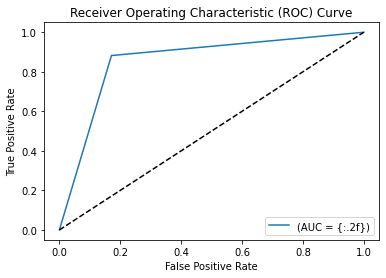

In [35]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(Y_predictions, Y_test)
auc = roc_auc_score(Y_predictions, Y_test)

plt.plot(fpr, tpr, label='(AUC = {:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()